21.98778891089654
98.27665823646812


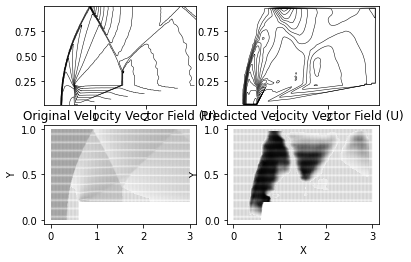

In [102]:
import os
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import random
from utils import read_final_simulation


def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


path_to_data = './data_with_C/data_step 2/'
path_to_low = os.path.join(path_to_data, 'low_dim')
path_to_high = os.path.join(path_to_data, 'high_dim')
simulation = 'vel3.747474747474748'

simulation_low = os.path.join(path_to_low, simulation)
C_low, U_low, p_low = read_final_simulation(simulation_low)

simulation_high = os.path.join(path_to_high, simulation)
C_high, U_high, p_high = read_final_simulation(simulation_high)

interpol_p = CloughTocher2DInterpolator(C_low[:, :2], p_low)

predicted_p = np.nan_to_num(interpol_p(C_high[:, 0], C_high[:, 1]))

interpol_u_x = CloughTocher2DInterpolator(C_low[:, :2], U_low[:, 1])
interpol_u_y = CloughTocher2DInterpolator(C_low[:, :2], U_low[:, 2])

predicted_u_x = np.nan_to_num(interpol_u_x(C_high[:, 0], C_high[:, 1]))
predicted_u_y = np.nan_to_num(interpol_u_y(C_high[:, 0], C_high[:, 1]))


fig, axes = plt.subplots(2, 2, squeeze=False)
original_ax = axes[0, 0]
triangulation = tri.Triangulation(C_high[:, 0], C_high[:, 1])

original_ax.tricontour(triangulation, p_high, levels=14, linewidths=0.5, colors='k')

predicted_ax = axes[0, 1]
predicted_ax.tricontour(triangulation, predicted_p, levels=14, linewidths=0.5, colors='k')

original_ax_u = axes[1, 0]
original_ax_u.quiver(C_high[:, 0], C_high[:, 1], U_high[:, 0], U_high[:, 1])

# Add labels and title
original_ax_u.set_xlabel("X")
original_ax_u.set_ylabel("Y")
original_ax_u.set_title("Original Velocity Vector Field (U)")

predicted_ax_u = axes[1, 1]
predicted_ax_u.quiver(C_high[:, 0], C_high[:, 1], predicted_u_x, predicted_u_y)

# Add labels and title
predicted_ax_u.set_xlabel("X")
predicted_ax_u.set_ylabel("Y")
predicted_ax_u.set_title("Predicted Velocity Vector Field (U)")

plt.savefig("pressure.png")
print(mape(p_high, predicted_p))

print(mape(U_high[:, :2], np.dstack((predicted_u_x, predicted_u_y))))



In [106]:
LOW_DIM = 'low_dim'
HIGH_DIM = 'high_dim'

path_to_geometry='./data_with_C/data_step 2/'

low_dim_files = [os.path.join(path_to_geometry,LOW_DIM, x) 
                 for x in os.listdir('./data_with_C/data_step 2/low_dim')
                 if x != '.DS_Store']
high_dim_files = [os.path.join(path_to_geometry,HIGH_DIM, x) 
                  for x in os.listdir('./data_with_C/data_step 2/high_dim')
                  if x != '.DS_Store']

data = list(zip(low_dim_files, high_dim_files))
random.shuffle(data)
train = data[:80]
val = data[80:]

In [110]:
def read_data(simulation_low, simulation_high):
    C_low, U_low, p_low = read_final_simulation(simulation_low)
    C_high, U_high, p_high = read_final_simulation(simulation_high)

    interpol_p = CloughTocher2DInterpolator(C_low[:, :2], p_low)

    predicted_p = np.nan_to_num(interpol_p(C_high[:, 0], C_high[:, 1]))

    interpol_u_x = CloughTocher2DInterpolator(C_low[:, :2], U_low[:, 1])
    interpol_u_y = CloughTocher2DInterpolator(C_low[:, :2], U_low[:, 2])

    predicted_u_x = np.nan_to_num(interpol_u_x(C_high[:, 0], C_high[:, 1]))
    predicted_u_y = np.nan_to_num(interpol_u_y(C_high[:, 0], C_high[:, 1]))


    return predicted_p, predicted_u_x, predicted_u_y, p_high, U_high[:, 0], U_high[:, 1]

In [114]:
pred_p, pred_u_x, pred_u_y, ans_p, ans_u_x, ans_u_y = read_data(data[0][0], data[0][1])

In [123]:
pred_p.shape

(16128,)

In [164]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

model = nn.Sequential(
          nn.Linear(16128,1024),
          nn.ReLU(),
          nn.Linear(1024,256),
          nn.ReLU(),
          nn.Linear(256,128),
          nn.ReLU(),
          nn.Linear(128,256),
          nn.ReLU(),
          nn.Linear(256,1024),
          nn.ReLU(),
          nn.Linear(1024,16128),
          nn.ReLU()
        )


In [167]:
def fit_epoch(model, train, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for obj in train:
        pred_p, pred_u_x, pred_u_y, ans_p, ans_u_x, ans_u_y = read_data(obj[0], obj[1])
        
        pred_p = torch.FloatTensor(pred_p)
        ans_p = torch.FloatTensor(ans_p)
       
        inputs = pred_p.to(DEVICE)
        labels = ans_p.to(DEVICE)
        
        for param in model.parameters():
            param.grad = None

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        processed_data += 1
        
    train_loss = running_loss / processed_data
    return train_loss


def eval_epoch(model, val, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for obj in val:
        pred_p, pred_u_x, pred_u_y, ans_p, ans_u_x, ans_u_y = read_data(obj[0], obj[1])
        pred_p = torch.FloatTensor(pred_p)
        ans_p = torch.FloatTensor(ans_p)
               
        inputs = pred_p.to(DEVICE)
        labels = ans_p.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs).to(DEVICE)
            running_loss += mean_absolute_percentage_error(labels.cpu(), outputs.cpu())
            processed_size += 1
    val_loss = running_loss / processed_size
    return val_loss
     

In [169]:
DEVICE = 'mps'
model = model.to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [199]:
from torchmetrics import MeanAbsolutePercentageError
history = []
for i in range(20):
    mse = fit_epoch(model, train, criterion, optimizer)
    mape = eval_epoch(model, val, criterion)
    print(mape)
    history.append(mape)

0.1319922309368849
0.10766355246305466


KeyboardInterrupt: 

In [200]:
def show_example(simulation_low, simulation_high):
    C_low, U_low, p_low = read_final_simulation(simulation_low)
    C_high, U_high, p_high = read_final_simulation(simulation_high)

    interpol_p = CloughTocher2DInterpolator(C_low[:, :2], p_low)

    predicted_p = np.nan_to_num(interpol_p(C_high[:, 0], C_high[:, 1]))

    interpol_u_x = CloughTocher2DInterpolator(C_low[:, :2], U_low[:, 1])
    interpol_u_y = CloughTocher2DInterpolator(C_low[:, :2], U_low[:, 2])

    predicted_u_x = np.nan_to_num(interpol_u_x(C_high[:, 0], C_high[:, 1]))
    predicted_u_y = np.nan_to_num(interpol_u_y(C_high[:, 0], C_high[:, 1]))

    pred_p = torch.FloatTensor(predicted_p)
    inputs = pred_p.to(DEVICE)

    with torch.set_grad_enabled(False):
        outputs = model(inputs).to(DEVICE)
 
    
    out, int_p, real_p, C_high = outputs, predicted_p, p_high, C_high
    
    fig, axes = plt.subplots(1, 3, figsize=(15,6), squeeze=False)
    original_ax = axes[0, 0]
    triangulation = tri.Triangulation(C_high[:, 0], C_high[:, 1])

    original_ax.tricontour(triangulation, p_high, levels=14, linewidths=0.5, colors='k')

    predicted_ax = axes[0, 1]
    predicted_ax.tricontour(triangulation, out.cpu(), levels=14, linewidths=0.5, colors='k')

    predicted_ax = axes[0, 2]
    predicted_ax.tricontour(triangulation, int_p, levels=14, linewidths=0.5, colors='k')


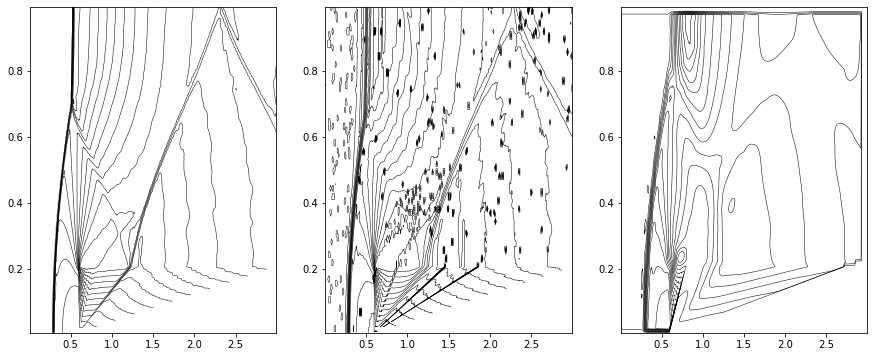

In [202]:
show_example(example[0], example[1])

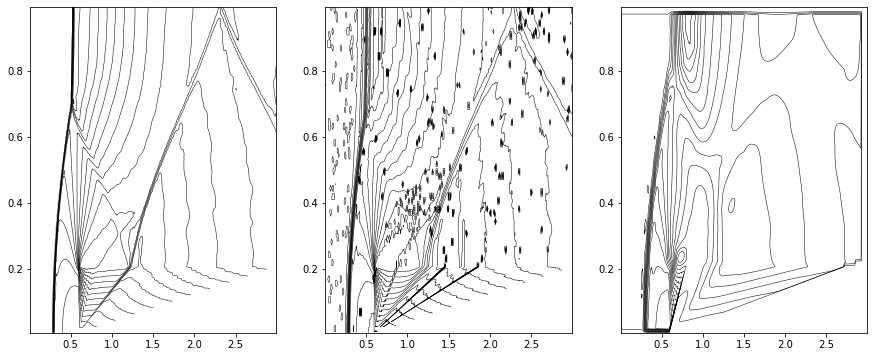

In [203]:
example = val[19]
show_example(example[0], example[1])